In [3]:
#!/usr/bin/env python3
# -*- coding:utf-8 -*-
import os
import json
import re
import csv
from scipy.stats import chi2_contingency
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
import math
import nltk
from nltk.corpus import stopwords

In [ ]:
# task1 data seperate
def seperate_task1():
    task_1_path = '../other_dict/task-1/task1.train.txt'
    with open(task_1_path,"r") as fin:
        row_num=0
        for line in fin.readlines(): 
            row_num+=1
            #row_num=35993
            if row_num%5==0: # we use the 1/5 of the propaganda articles,(335993/5=7198)
                line_split = line.strip().split("\t")
                if len(line_split)==3:
                    context = line_split[0]
                    fileName = "_".join(line_split[1:])
                    fout = open('../other_dict/task-1/task1_article_seperate/'+fileName,"w")
                    fout.write(context)
                    fout.close()
seperate_task1()

In [4]:
#pos-tagging
def tag_cnt_func(fileName):
    with open('../other_dict/task-1/task1_article_seperate/'+fileName,"r") as fin:
        text = fin.read()
        text = text.lower()
#         print(text)
        text_list = nltk.word_tokenize(text)
        english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']
        #remove stopwords and puntuation
        stops = set(stopwords.words("english"))
        text_list = [word for word in text_list if word not in stops and word not in english_punctuations]
        text_tag = nltk.pos_tag(text_list)
        tag_list = ['CC','CD','DT','EX','FW','IN','JJ',
                    'JJR','JJS','LS','MD','NN','NNS','NNP',
                    'NNPS','PDT','POS','PRP','PRP','RB','RBR','RBS','RP',
                    'SYM','TO','UH','VB','VBD','VBG','VBN','VBP','VBZ','WDT','WP','WP','WRB','WP$','$']
        tag_cnt_dict = dict()
        for tag in tag_list:
            tag_cnt_dict[tag]=0
        for pair in text_tag:
            if pair[1] in tag_list:
                tag_cnt_dict[pair[1]] += 1
        nltk.pos_tag
        return([tag_cnt_dict[tag] for tag in tag_list])

In [5]:
# generate NELA feature for task1, see NELA project
# load task1 seperated data
def load_NELA_feature():
        feature_path = "../other_dict/task-1/train_harvest_tool_out/processed_data.csv"
        fileName_feature_dict = dict()
        with open(feature_path,'r') as f:
            i=0
            for line in f.readlines():
                i+=1
                #print(str(i) + " article has been processed.")
                if i>2:
                    pass
                line_split = line.strip().split(",")
                tag_feature = tag_cnt_func(line_split[0])
                tag_feature.extend([float(i) for i in line_split[3:]])
                fileName_feature_dict[line_split[0]] = tag_feature
        return fileName_feature_dict 
task1_NELA_dict = load_NELA_feature()
feature_label_list = []
for fileName,feature in task1_NELA_dict.items():
    feature_label = feature.append(fileName.split("_")[1]=="propaganda")
    feature_label_list.append(feature)
np.random.shuffle(feature_label_list)
print('feature_label_list',feature_label_list[:100])
# partition to positive/negative
global_sentence_label_positive = [pair for pair in feature_label_list if pair[-1]==True]
global_sentence_label_negative = [pair for pair in feature_label_list if pair[-1]==False][:804]
print(len(feature_label_list),len(global_sentence_label_positive),len(global_sentence_label_negative))

train_dataset = global_sentence_label_negative[:int(len(global_sentence_label_negative)*0.8)]
train_dataset.extend(global_sentence_label_positive[:int(len(global_sentence_label_positive)*0.8)])

validation_dataset = global_sentence_label_negative[int(len(global_sentence_label_negative)*0.8):int(len(global_sentence_label_negative)*0.9)]
validation_dataset.extend(global_sentence_label_positive[int(len(global_sentence_label_negative)*0.8):int(len(global_sentence_label_negative)*0.9)])

test_dataset = global_sentence_label_negative[int(len(global_sentence_label_negative)*0.9):]
test_dataset.extend(global_sentence_label_positive[int(len(global_sentence_label_positive)*0.9):])

def convert_to_array(dataset):
    feature = np.array([line[:-1] for line in dataset])
    label = np.array([line[-1] for line in dataset])
    return feature,label
train_feature_matrix, train_label = convert_to_array(train_dataset)
validation_feature_matrix, validation_label = convert_to_array(validation_dataset)
test_feature_matrix, test_label = convert_to_array(test_dataset)

feature_label_list [[0, 9, 0, 0, 0, 1, 46, 0, 1, 0, 0, 98, 25, 0, 0, 0, 6, 1, 1, 10, 1, 0, 0, 1, 0, 0, 6, 22, 8, 6, 7, 4, 0, 0, 0, 0, 0, 0, 0.0, 0.0, 0.0, 0.0, 0.0042643923240938165, 0.0, 0.01279317697228145, 0.0, 0.0, 0.0, 0.0, 0.06823027718550102, 0.006396588486140725, 0.0021321961620469083, 0.008528784648187633, 0.0, 0.019189765458422173, 0.010660980810234541, 0.025586353944562892, 0.017057569296375266, 0.0042643923240938165, 0.025586353944562892, 0.008528784648187633, 0.019189765458422173, 0.0021321961620469083, 0.6551724137931034, 0.119, 0.84, 0.041, 0.32196162046908317, 5.059748427672956, 469.0, 0.9804129681869739, 0.01958703181302843, 2.1321961620469083, 0.21321961620469082, 10.021321961620469, 0.017057569296375266, 12.4962, 12.16515138991168, 0.03940886699507389, 0.017241379310344827, 0.08374384236453201, 0.0024630541871921183, 0.0, 0.10837438423645321, 0.07142857142857142, 0.0024630541871921183, 0.0, 0.0, 0.0049261083743842365, 0.15763546798029557, 0.04926108374384237, 0.15763

In [6]:
len(train_dataset[0])

179

The train accuracy score of rf is : 0.861586
The test accuracy score of rf is : 0.845679
confusion matrix is  [[72  9]
 [16 65]]
[[0.88888889 0.11111111]
 [0.19753086 0.80246914]]
The train accuracy score of rf is : 0.861586
The test accuracy score of rf is : 0.845679
confusion matrix is  [[72  9]
 [16 65]]
[[0.88888889 0.11111111]
 [0.19753086 0.80246914]]


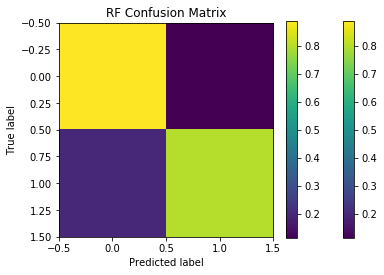

In [7]:
#gbdt, train and tune parameter
gbdt = GradientBoostingClassifier(max_depth=4,
                                  random_state=0,
                                  min_samples_split=5,
                                  learning_rate=0.01,
                                  n_estimators=30,
                                  subsample=0.8)
rf = gbdt.fit(train_feature_matrix, train_label)
val_score_rbf = gbdt.score(train_feature_matrix, train_label)
print("The train accuracy score of rf is : %f" % val_score_rbf)
test_score_rbf = gbdt.score(test_feature_matrix, test_label)
print("The test accuracy score of rf is : %f" % test_score_rbf)
predict_label = gbdt.predict(test_feature_matrix)
# confusion matrix 
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]   
    plt.imshow(cm)    
    print(cm)
    plt.title(title) 
    plt.colorbar()
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_label, predict_label)
print("confusion matrix is ", cm)
plot_confusion_matrix(cm, "RF Confusion Matrix")

#gbdt train again and predict
gbdt = GradientBoostingClassifier(max_depth=4,
                                  random_state=0,
                                  min_samples_split=5,
                                  learning_rate=0.01,
                                  n_estimators=30,
                                  subsample=0.8)
rf = gbdt.fit(train_feature_matrix, train_label)
val_score_rbf = gbdt.score(train_feature_matrix, train_label)
print("The train accuracy score of rf is : %f" % val_score_rbf)
test_score_rbf = gbdt.score(test_feature_matrix, test_label)
print("The test accuracy score of rf is : %f" % test_score_rbf)
predict_label = gbdt.predict(test_feature_matrix)
# confusion matrix 
def plot_confusion_matrix(cm, title):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  
    plt.imshow(cm)   
    print(cm)
    plt.title(title)   
    plt.colorbar()
    plt.ylabel('True label')    
    plt.xlabel('Predicted label')
cm = confusion_matrix(test_label, predict_label)
print("confusion matrix is ", cm)
plot_confusion_matrix(cm, "RF Confusion Matrix")